In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd
import scipy.optimize as opt
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import seaborn as sns
import re
import matplotlib.backends.backend_pdf
import os
import time
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from matplotlib import gridspec
from PIL import Image
from random import Random
import scipy.stats as stt

2023-01-27 13:32:02.524 INFO    numexpr.utils: NumExpr defaulting to 8 threads.
2023-01-27 13:32:05.388 INFO    rdkit: Enabling RDKit 2020.09.1 jupyter extensions


In [2]:

def split_data(dataset):
    dataset=dataset.sample(frac=1)
    length= len(dataset)
    eightypercent= int(length*0.8)
    trainingset= dataset[:eightypercent]
    testset=dataset[eightypercent:]
    return trainingset, testset

def re_round(li, _prec=3):
    ''' Rounds argument li to desired number of decimals (_prec) '''
    try:
         return round(li, _prec)
    except TypeError:
         return type(li)(re_round(x, _prec) for x in li)
             
def findstr(test_str,test_sub):
    res = [i for i in range(len(test_str)) if test_str.startswith(test_sub, i)]
    return res
    
def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

def split_data(dataset):
    dataset=dataset.sample(frac=1)
    length= len(dataset)
    eightypercent= int(length*0.8)
    trainingset= dataset[:eightypercent]
    testset=dataset[eightypercent:]
    return trainingset, testset

def fit_tm_model(predictors,*parameter):
    parameters= parameter
    return eval(model_form)

def fit_tm_model_err(predictors,*parameter):
    parameters= parameter[0]
    return eval(model_form)

def make_plots(dataset_test,dataset_train,letters_in_use, dataset_name):
    Tbuffer= 25
    lowerT =min ( min(dataset_test['T_m (K)']),min(dataset_train['T_m (K)']),min(fit_tm_model_err(dataset_test,letters_in_use)),min (fit_tm_model_err(dataset_train,letters_in_use))) - 273
    lowerT=lowerT- Tbuffer

    higherT =max( max(dataset_test['T_m (K)']),max(dataset_train['T_m (K)'])
    ,max(fit_tm_model_err(dataset_test,
    letters_in_use)),max(fit_tm_model_err(dataset_train,letters_in_use))) - 273
    higherT=higherT+Tbuffer

    
    fig, ax=plt.subplots(figsize=(4,4), dpi=300)
    
    #ax.figure(figsize=(4,4), dpi=300)
    ax.plot(dataset_train['T_m (K)']-273,fit_tm_model_err(dataset_train,
    letters_in_use)-273,'ko',markersize=4)
    ax.plot(dataset_test['T_m (K)']-273,fit_tm_model_err(dataset_test,
    letters_in_use)-273,'ro',markersize=4)
    ax.plot([lowerT,higherT],[lowerT,higherT],color=((0.6,0.6,0.6)))
    ax.set_ylabel('Predicted $T_m$ (°C)')
    ax.set_xlabel('Experimental $T_m$ (°C)')
    #ax.set_title('Calculated vs Experimental $T_m$ for '+ model_form_name + ' - ' + dataset_name +'\n Test Error: ' + str(avg_model_err[0])+ '\n Train Error: ' + str(avg_model_err[1]) + '\n RMSE Test:'+ str(rmse_err[0])+ '\n RMSE Train:'+str(rmse_err[1]))
    ax.legend(('Training Set','Test Set'))
    ax.set_xlim([lowerT,higherT])
    ax.set_ylim([lowerT,higherT])
    return fig

# function to calculate root mean square error
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Function for rounding tuples in confidence intervals - copied from online
def re_round(li, _prec=3):
    ''' Rounds argument li to desired number of decimals (_prec) '''
    try:
         return round(li, _prec)
    except TypeError:
         return type(li)(re_round(x, _prec) for x in li)

def vbt_model_automated(dataset_dictionary, dataset_name, model_form, starting_guesses, number_of_runs):
    '''Generates a dictionary of VBT model plot, Avg Absolute Error, RMSE Error, and Parameter values'''
    all_possible_predictors= ['tau', 'V_m (nm3)', 'sigma','Eccentricity(Eal)', 'Eccentricity(Ear)']
    letters_in_use= ['a','b','c','d','f','g','h','k','l','m']
    predicted= ['T_m (K)']
    used_predictors= []
    # This for loop finds which parameters are used in the model form and adds them to a list of used predictors
    for i in range(len(all_possible_predictors)):
        this_predictor= all_possible_predictors[i]
        if findstr(model_form, this_predictor):
            used_predictors.append(this_predictor)
    used_predictors= used_predictors+predicted
    num_parameters= len(findstr(model_form, 'parameter'))

    if num_parameters!=len(starting_guesses):
        raise Exception("Number of starting guesses doesn't match the number of parameters")

    letters_in_use=letters_in_use[0:num_parameters]
    num_parameters= list(range(num_parameters))
    train_avg_err=[]
    test_avg_err=[]
    train_rmse_err=[]
    test_rmse_err=[]
    train_r2 = []
    test_r2 = []
    count=0
    parameters_from_runs=np.zeros((number_of_runs,len(num_parameters)))
    dataset= dataset_dictionary[dataset_name]
    #dataset_length= len(dataset)
    predictors=dataset[used_predictors].astype('float64')
    while count < number_of_runs:
        [dataset_train,dataset_test]=split_data(predictors)
        (letters_in_use,_)=opt.curve_fit(fit_tm_model,dataset_train,dataset_train['T_m (K)'],(starting_guesses))
        parameters_from_runs[count,:]=letters_in_use
        train_avg_err.append(statistics.mean(np.absolute(fit_tm_model_err(dataset_train,letters_in_use)-dataset_train['T_m (K)'])))
        test_avg_err.append(statistics.mean(np.absolute(fit_tm_model_err(dataset_test,letters_in_use)-dataset_test['T_m (K)'])))
        train_rmse_err.append(rmse((fit_tm_model_err(dataset_train,letters_in_use)),dataset_train['T_m (K)']))
        test_rmse_err.append(rmse((fit_tm_model_err(dataset_test,letters_in_use)),dataset_test['T_m (K)']))
        train_r2.append(r2_score(dataset_train['T_m (K)'],(fit_tm_model_err(dataset_train,letters_in_use))))
        test_r2.append(r2_score(dataset_test['T_m (K)'],(fit_tm_model_err(dataset_test,letters_in_use))))
        count = count+1

    fig=make_plots(dataset_test,dataset_train,letters_in_use,dataset_name)
    
    ci_int_val=0.95
    dec_points=3

    ind_names=[]
    for i in range(1,num_runs+1):
        ind_names.append('Run ' + str(i))#print(rmse_err)
    errors = pd.DataFrame(list(zip(train_avg_err,test_avg_err,train_rmse_err,test_rmse_err,train_r2,test_r2)),columns=['Train AAE','Test AAE','Train RMSE','Test RMSE','Train R^2','Test R^2'],index=ind_names).round(decimals=dec_points)

    mean_list=[]
    ci_list=[]

    for column in errors:
        mean_list.append(np.mean(errors[column]))
        ci_list.append(stt.t.interval(ci_int_val,len(errors[column])-1, np.mean(errors[column]), stt.sem(errors[column]))) 
    errors.loc['Mean'] = re_round(mean_list,dec_points)
    errors.loc['95% CI'] = re_round(ci_list,dec_points)

    calc_parameters = pd.DataFrame(np.around(parameters_from_runs,dec_points),index=ind_names)
    mean_list_p = []
    ci_list_p = []
    for column in calc_parameters:
        mean_list_p.append(np.mean(calc_parameters[column]))
        ci_list_p.append(stt.t.interval(ci_int_val,len(calc_parameters[column])-1, np.mean(calc_parameters[column]), stt.sem(calc_parameters[column])))
    calc_parameters.loc['Mean'] = re_round(mean_list_p,dec_points)
    calc_parameters.loc['95% CI'] = re_round(ci_list_p,dec_points)
    model_dict = {
        'Plot': fig,
        'Errors': errors,
        'Parameters': calc_parameters
    }
    plt.close()
    return model_dict


In [19]:

def get_optimal_params(vbt_dataset_dict,dataset_key):
    if dataset_key=='Quinones':
        working_ML_dataset=pd.read_csv('Data Files/featurized_bq.csv',low_memory=False)
    elif dataset_key=='Hydroquinones':
        working_ML_dataset=pd.read_csv('Data Files/featurized_hq.csv',low_memory=False)
    
    [trainset,testset] = split_data(working_ML_dataset)
    trainset = trainset.reset_index()
    testset = testset.reset_index()   

    columns_to_drop = ['InChI Key','SMILES','Type of Substance','mp_mean','mp_std','LogP','H Bond Donors','H Bond Acceptors','Rotatable Bonds','TPSA','Lipinski Number','Veber Number','MAXdO','MINdO','index']

    trainset_s = trainset.drop(columns=columns_to_drop)
    testset_s = testset.drop(columns=columns_to_drop)

    # drop columns where there is an error from mordred
    trainset_s = trainset_s.select_dtypes(include=['float64','int'])

    # drop the same columns from the test set
    testset_s = testset_s[trainset_s.columns]  

    y = trainset.mp_mean.tolist()
    y_test = testset.mp_mean.tolist()

    parameters = {'n_estimators':[10,20,40,80],
                    'max_depth':[2,4,6,8],
                    'min_samples_split':[2,4,8],
                    # 'min_samples_leaf':[1,2,5,10,20],
                    # 'max_features': [1,2,5],
                    # 'max_leaf_nodes':[None,1,2,5,10,20,100],
                    'ccp_alpha': [1,2,3]
                    }

    rf = RandomForestRegressor()
    grid = GridSearchCV(rf,parameters,refit=True,cv=10)
    grid.fit(trainset_s,y)
    print(grid.best_params_)
    opt_params = grid.best_params_
    print(opt_params)

    rf = RandomForestRegressor(**opt_params)
    rf.fit(trainset_s,y)

    print("Train AAE: " + str(np.mean(np.abs(y-(rf.predict(trainset_s))))))
    print("Test AAE: " + str(np.mean(np.abs(y_test-(rf.predict(testset_s))))))

    return opt_params

def ml_model_vbt_features_multipleruns(vbt_dataset_dict,dataset_key,alpha=1,number_of_runs=100):
    
    full_dataset = vbt_dataset_dict[dataset_key][['sigma','tau','V_m (nm3)','T_m (K)','Eccentricity(Ear)','Eccentricity(Eal)']]

    train_avg_err=[]
    test_avg_err=[]
    train_rmse_err=[]
    test_rmse_err=[]
    train_r2 = []
    test_r2 = []
    runs = ["Run " + str(i+1) for i in range(number_of_runs)]
    weights = pd.DataFrame(columns = ['sigma','tau','V_m (nm3)','Eccentricity(Ear)','Eccentricity(Eal)'],index=runs)

    count = 1
    while count < number_of_runs + 1:
        [trainset,testset] = split_data(full_dataset)
        y = (trainset['T_m (K)']-273).tolist()
        y_test = (testset['T_m (K)']-273).tolist()
        trainset = trainset.drop(columns = ['T_m (K)'])
        testset = testset.drop(columns = ['T_m (K)'])
        scaler = preprocessing.StandardScaler().fit(trainset)
        X = scaler.transform(trainset)
        X_test = scaler.transform(testset)
        rr = Ridge(alpha=alpha)
        rr.fit(X, y)
        w = rr.coef_
        intercept = rr.intercept_
        
        train_avg_err.append(np.mean(np.abs(y-(np.dot(X,w)+intercept))))
        test_avg_err.append(np.mean(np.abs(y_test-(np.dot(X_test,w)+intercept))))
        train_rmse_err.append(np.sqrt(((y - (np.dot(X,w)+intercept)) ** 2).mean()))
        test_rmse_err.append(np.sqrt(((y_test-(np.dot(X_test,w)+intercept))**2).mean()))
        train_r2.append(r2_score(y,(np.dot(X,w)+intercept)))
        test_r2.append(r2_score(y_test,(np.dot(X_test,w)+intercept)))
        
        weights.loc["Run " + str(count),:] = w
        count = count + 1
    
    ci_int_val=0.95
    dec_points=3

    errors = pd.DataFrame(list(zip(train_avg_err,test_avg_err,train_rmse_err,test_rmse_err,train_r2,test_r2)),columns=['Train AAE','Test AAE','Train RMSE','Test RMSE','Train R^2','Test R^2'],index=runs).round(decimals=dec_points)

    mean_list = [np.mean(errors[column]) for column in errors]
    ci_list = [stt.t.interval(ci_int_val,len(errors[column])-1, np.mean(errors[column]), stt.sem(errors[column])) for column in errors]
    errors.loc['Mean'] = np.around(mean_list,dec_points)
    errors.loc['95% CI'] = re_round(ci_list,dec_points)

    mean_list = [np.mean(weights[column]) for column in weights]
    ci_list = [stt.t.interval(ci_int_val,len(weights[column])-1, np.mean(weights[column]), stt.sem(weights[column])) for column in weights]
    weights.loc['Mean'] = np.around(mean_list,dec_points)
    weights.loc['95% CI'] = re_round(ci_list,dec_points)

    # Make plot
    model_plot=plt.figure(figsize=(4,4), dpi=300)
    ax1 = plt.gca()
    ml_plot_train_points=ax1.scatter(y,np.dot(X,w)+intercept,c='k',alpha=1,linewidth=0)
    ax1.plot([-273,2000],[-273,2000],'k--',lw=1)
    ml_plot_test_points=ax1.scatter(y_test,np.dot(X_test,w)+intercept,c='r',alpha=1,linewidth=0)
    lims = [min(y+y_test)-15,max(y+y_test)+15]
    for theaxis in [ax1]:        
        theaxis.set_aspect(1)
        theaxis.set_xlim(lims)
        theaxis.set_ylim(lims)
        theaxis.set_xlabel(r"Experimental $T_m$ ($^{\circ}$C)")
        theaxis.set_ylabel(r"Predicted $T_m$ ($^{\circ}$C)")
        
        for item in ([theaxis.xaxis.label, theaxis.yaxis.label, theaxis.yaxis.get_offset_text(), theaxis.xaxis.get_offset_text()]):
            item.set_fontsize(12)
        for item in (theaxis.get_xticklabels() + theaxis.get_yticklabels()):
            item.set_fontsize(10)
    plt.legend((ml_plot_train_points,ml_plot_test_points),('Training Set','Test Set'))    
    plt.gcf().subplots_adjust(left=0.2,top=0.95,bottom=0.15,right=0.95)
   
    plt.close()
    
    ml_model_dict={
        'Plot': model_plot,
        'Errors': errors,
        'Model Coefficients': weights
    }
    return ml_model_dict

def rf_model_vbt_features_multipleruns(vbt_dataset_dict,dataset_key,number_of_runs=100):
    
    full_dataset = vbt_dataset_dict[dataset_key][['sigma','tau','V_m (nm3)','T_m (K)','Eccentricity(Ear)','Eccentricity(Eal)']]

    train_avg_err=[]
    test_avg_err=[]
    train_rmse_err=[]
    test_rmse_err=[]
    train_r2 = []
    test_r2 = []
    runs = ["Run " + str(i+1) for i in range(number_of_runs)]
    weights = pd.DataFrame(columns = ['sigma','tau','V_m (nm3)','Eccentricity(Ear)','Eccentricity(Eal)'],index=runs)

    count = 1
    while count < number_of_runs + 1:
        trainset,testset = split_data(full_dataset)
        y = (trainset['T_m (K)']-273).tolist()
        y_test = (testset['T_m (K)']-273).tolist()
        trainset = trainset.drop(columns = ['T_m (K)'])
        testset = testset.drop(columns = ['T_m (K)'])
        scaler = preprocessing.StandardScaler().fit(trainset)
        # y_scaler = preprocessing.StandardScaler().fit(np.array(y).reshape(-1, 1))
        # y = y_scaler.transform(np.array(y))
        # y_test = y_scaler.transform(np.array(y_test))
        X = scaler.transform(trainset)
        X_test = scaler.transform(testset)
        # X = trainset
        # X_test = testset
        # opt_params = {'ccp_alpha': 3, 'max_depth': 2, 'min_samples_split': 24, 'n_estimators': 20}
        # rf = MLPRegressor(max_iter=1000)
        rf = RandomForestRegressor(n_jobs=-1)
        rf.fit(X, y)
        # w = rr.coef_
        # intercept = rr.intercept_
        
        train_avg_err.append(np.mean(np.abs(y-(rf.predict(X)))))
        test_avg_err.append(np.mean(np.abs(y_test-(rf.predict(X_test)))))
        train_rmse_err.append(np.sqrt(((y - (rf.predict(X))) ** 2).mean()))
        test_rmse_err.append(np.sqrt(((y_test-(rf.predict(X_test)))**2).mean()))
        train_r2.append(r2_score(y,rf.predict(X)))
        test_r2.append(r2_score(y_test,rf.predict(X_test)))
        weights.loc["Run " + str(count),:] = rf.feature_importances_
        count = count + 1
    
    ci_int_val=0.95
    dec_points=3

    #### Test Figure for looking at distributions ####
    # fig = plt.figure(figsize=(5,5))
    # plt.hist(y,alpha=0.8)
    # plt.hist(y_test,alpha=0.8)

    errors = pd.DataFrame(list(zip(train_avg_err,test_avg_err,train_rmse_err,test_rmse_err,train_r2,test_r2)),columns=['Train AAE','Test AAE','Train RMSE','Test RMSE','Train R^2','Test R^2'],index=runs).round(decimals=dec_points)

    mean_list = [np.mean(errors[column]) for column in errors]
    ci_list = [stt.t.interval(ci_int_val,len(errors[column])-1, np.mean(errors[column]), stt.sem(errors[column])) for column in errors]
    errors.loc['Mean'] = np.around(mean_list,dec_points)
    errors.loc['95% CI'] = re_round(ci_list,dec_points)

    mean_list = [np.mean(weights[column]) for column in weights]
    ci_list = [stt.t.interval(ci_int_val,len(weights[column])-1, np.mean(weights[column]), stt.sem(weights[column])) for column in weights]
    weights.loc['Mean'] = np.around(mean_list,dec_points)
    weights.loc['95% CI'] = re_round(ci_list,dec_points)

    # Make plot
    model_plot=plt.figure(figsize=(4,4), dpi=300)
    ax1 = plt.gca()
    ml_plot_train_points=ax1.scatter(y,rf.predict(X),c='k',alpha=1,linewidth=0)
    ax1.plot([-273,2000],[-273,2000],'k--',lw=1)
    ml_plot_test_points=ax1.scatter(y_test,rf.predict(X_test),c='r',alpha=1,linewidth=0)
    lims = [min(y+y_test)-15,max(y+y_test)+15]
    for theaxis in [ax1]:        
        theaxis.set_aspect(1)
        theaxis.set_xlim(lims)
        theaxis.set_ylim(lims)
        theaxis.set_xlabel(r"Experimental $T_m$ ($^{\circ}$C)")
        theaxis.set_ylabel(r"Predicted $T_m$ ($^{\circ}$C)")
        
        for item in ([theaxis.xaxis.label, theaxis.yaxis.label, theaxis.yaxis.get_offset_text(), theaxis.xaxis.get_offset_text()]):
            item.set_fontsize(12)
        for item in (theaxis.get_xticklabels() + theaxis.get_yticklabels()):
            item.set_fontsize(10)
    plt.legend((ml_plot_train_points,ml_plot_test_points),('Training Set','Test Set'))    
    plt.gcf().subplots_adjust(left=0.2,top=0.95,bottom=0.15,right=0.95)
   
    plt.close()
    
    ml_model_dict={
        'Plot': model_plot,
        'Errors': errors,
        'Feature Importances': weights
    }
    return ml_model_dict

def ml_model_multipleruns(ml_dataset_dict, dataset_key, alpha=100, number_of_runs=5, do_featurization = False):  
    if do_featurization:

        working_ML_dataset=ml_dataset_dict[dataset_key]
        mols_full=[Chem.MolFromSmiles(m) for m in working_ML_dataset.SMILES.tolist() if Chem.MolFromSmiles(m) != None]
        calc = Calculator(descriptors, ignore_3D=True)
        mordredresults = calc.pandas(mols_full)
        working_ML_dataset = working_ML_dataset.join(mordredresults,how='inner')
        # save to the appropriate file name depending on which dataset you're looking at
        if dataset_key=='Quinones':
            working_ML_dataset.to_csv('Data Files/featurized_bq.csv',index=False)
        elif dataset_key=='Hydroquinones':
            working_ML_dataset.to_csv('Data Files/featurized_hq.csv',index=False)
        else:
            print('Not a valid dataset key')            
    else:
        if dataset_key=='Quinones':
            working_ML_dataset=pd.read_csv('Data Files/featurized_bq.csv',low_memory=False)
        elif dataset_key=='Hydroquinones':
            working_ML_dataset=pd.read_csv('Data Files/featurized_hq.csv',low_memory=False)

    train_avg_err=[]
    test_avg_err=[]
    train_rmse_err=[]
    test_rmse_err=[]
    train_r2 = []
    test_r2 = []
    runs = ["Run " + str(i+1) for i in range(number_of_runs)]
    weights = pd.DataFrame(columns = working_ML_dataset.columns.tolist(),index=runs)

    count = 1
    while count < number_of_runs + 1:
        [trainset,testset] = split_data(working_ML_dataset)
        trainset = trainset.reset_index()
        testset = testset.reset_index()        
        
        ######
        ## Standardization (want each feature to be a gaussian with zero mean and unit variance)
        ######

        # drop non-numeric columns and ones for the melting point, so we only have columns of features
        # I don't know why, but LogP caused a problem during the standardization - dropping for now, but have to figure out
        # Now dropping everything but MW from the Reaxys, since we don't have it for the Na and K salts
        # columns_to_drop_from_reaxys = ['InChI Key','SMILES','Type of Substance','mp_mean','mp_std','LogP','H Bond Donors','H Bond Acceptors','Rotatable Bonds','TPSA','Lipinski Number','Veber Number','MAXdO','MINdO']
        columns_to_drop = ['InChI Key','SMILES','Type of Substance','mp_mean','mp_std','LogP','H Bond Donors','H Bond Acceptors','Rotatable Bonds','TPSA','Lipinski Number','Veber Number','MAXdO','MINdO','index']

        # if dataset_key=='Quinones':
        #     columns_to_drop_thatgavetrouble = ['MAXdO','MINdO']
        #     # for bq these gave trouble: ['Unnamed: 0','MAXdO','MINdO']
        # elif dataset_key=='Hydroquinones':
        #     columns_to_drop_thatgavetrouble = ['MAXdO','MINdO']

        # columns_to_drop = columns_to_drop_from_reaxys + columns_to_drop_thatgavetrouble
        trainset_s = trainset.drop(columns=columns_to_drop)
        testset_s = testset.drop(columns=columns_to_drop)

        # drop columns where there is an error from mordred
        #print('Started with '+str(len(trainset_s.columns))+' features')
        trainset_s = trainset_s.select_dtypes(include=['float64','int'])

        #print('After dropping columns with mordred errors, have '+str(len(trainset_s.columns))+' features')

        # drop the same columns from the test set
        testset_s = testset_s[trainset_s.columns]

        # finally, do the standardization
        # X = preprocessing.scale(trainset_s)
        # apply the same standardization to the test set
        scaler = preprocessing.StandardScaler().fit(trainset_s)
        X = scaler.transform(trainset_s)
        X_test = scaler.transform(testset_s)

        ######
        ## Ridge regression
        ######

        y = trainset.mp_mean.tolist()
        y_test = testset.mp_mean.tolist()

        rr = Ridge(alpha=alpha)
        rr.fit(X, y)
        w = rr.coef_
        intercept = rr.intercept_

        # avg_abs_err = np.zeros(2)
        # rmse_err = np.zeros(2)
        # The test set is at the 0 index and the training set is at the 1 index to match the convention in the other model 
        train_avg_err.append(np.mean(np.abs(y-(np.dot(X,w)+intercept))))
        test_avg_err.append(np.mean(np.abs(y_test-(np.dot(X_test,w)+intercept))))
        train_rmse_err.append(np.sqrt(((y - (np.dot(X,w)+intercept)) ** 2).mean()))
        test_rmse_err.append(np.sqrt(((y_test-(np.dot(X_test,w)+intercept))**2).mean()))
        train_r2.append(r2_score(y,(np.dot(X,w)+intercept)))
        test_r2.append(r2_score(y_test,(np.dot(X_test,w)+intercept)))

        if count == 1:
            weights = pd.DataFrame(index=runs,columns=trainset_s.columns)
        # coeffs = pd.DataFrame(data={'label':trainset_s.columns, 'w':w, 'w_abs':np.abs(w)})
        weights.loc["Run " + str(count),:] = w

        count = count + 1
    
    ci_int_val=0.95
    dec_points=3
    
    errors = pd.DataFrame(list(zip(train_avg_err,test_avg_err,train_rmse_err,test_rmse_err,train_r2,test_r2)),columns=['Train AAE','Test AAE','Train RMSE','Test RMSE','Train R^2','Test R^2'],index=runs).round(decimals=dec_points)

    mean_list = [np.mean(errors[column]) for column in errors]
    ci_list = [stt.t.interval(ci_int_val,len(errors[column])-1, np.mean(errors[column]), stt.sem(errors[column])) for column in errors]
    errors.loc['Mean'] = np.around(mean_list,dec_points)
    errors.loc['95% CI'] = re_round(ci_list,dec_points)

    mean_list = [np.mean(weights[column]) for column in weights]
    ci_list = [stt.t.interval(ci_int_val,len(weights[column])-1, np.mean(weights[column]), stt.sem(weights[column])) for column in weights]
    weights.loc['Mean'] = np.around(mean_list,dec_points)
    weights.loc["Absolute Mean"] = np.abs(weights.loc["Mean"])
    weights.loc['95% CI'] = re_round(ci_list,dec_points)
    # Sort by the mean weight in descending order
    weights.sort_values(by=["Absolute Mean"],axis=1,ascending=False,inplace=True)

    # Make plot
    model_plot=plt.figure(figsize=(4,4), dpi=300)
    ax1 = plt.gca()
    ml_plot_train_points=ax1.scatter(y,np.dot(X,w)+intercept,s=5,c='k',alpha=0.7,linewidth=0)
    ax1.plot([-273,2000],[-273,2000],'k--',lw=1)
    ml_plot_test_points=ax1.scatter(y_test,np.dot(X_test,w)+intercept,s=5,c='r',alpha=0.7,linewidth=0)

    lims = [min(y+y_test)-5,max(y+y_test)+5]

    for theaxis in [ax1]:
        
        theaxis.set_aspect(1)
        theaxis.set_xlim(lims)
        theaxis.set_ylim(lims)

        theaxis.set_xlabel(r"Experimental $T_m$ ($^{\circ}$C)")
        theaxis.set_ylabel(r"Predicted $T_m$ ($^{\circ}$C)")
        
        for item in ([theaxis.xaxis.label, theaxis.yaxis.label, theaxis.yaxis.get_offset_text(), theaxis.xaxis.get_offset_text()]):
            item.set_fontsize(12)
        for item in (theaxis.get_xticklabels() + theaxis.get_yticklabels()):
            item.set_fontsize(10)
    plt.legend((ml_plot_train_points,ml_plot_test_points),('Training Set','Test Set'))    
    plt.gcf().subplots_adjust(left=0.2,top=0.95,bottom=0.15,right=0.95)
   
    plt.close()

    ml_model_dict={
        'Plot': model_plot,
        'Errors': errors,
        'Model Coefficients': weights
    }
    return ml_model_dict

def rf_model_multipleruns(ml_dataset_dict, dataset_key, number_of_runs=5, do_featurization = False):  
    if do_featurization:

        working_ML_dataset=ml_dataset_dict[dataset_key]
        mols_full=[Chem.MolFromSmiles(m) for m in working_ML_dataset.SMILES.tolist() if Chem.MolFromSmiles(m) != None]
        calc = Calculator(descriptors, ignore_3D=True)
        mordredresults = calc.pandas(mols_full)
        working_ML_dataset = working_ML_dataset.join(mordredresults,how='inner')
        # save to the appropriate file name depending on which dataset you're looking at
        if dataset_key=='Quinones':
            working_ML_dataset.to_csv('Data Files/featurized_bq.csv',index=False)
        elif dataset_key=='Hydroquinones':
            working_ML_dataset.to_csv('Data Files/featurized_hq.csv',index=False)
        else:
            print('Not a valid dataset key')            
    else:
        if dataset_key=='Quinones':
            working_ML_dataset=pd.read_csv('Data Files/featurized_bq.csv',low_memory=False)
        elif dataset_key=='Hydroquinones':
            working_ML_dataset=pd.read_csv('Data Files/featurized_hq.csv',low_memory=False)

    train_avg_err=[]
    test_avg_err=[]
    train_rmse_err=[]
    test_rmse_err=[]
    train_r2 = []
    test_r2 = []
    runs = ["Run " + str(i+1) for i in range(number_of_runs)]
    weights = pd.DataFrame(columns = working_ML_dataset.columns.tolist(),index=runs)

    count = 1
    while count < number_of_runs + 1:
        [trainset,testset] = split_data(working_ML_dataset)
        trainset = trainset.reset_index()
        testset = testset.reset_index()        
        
        ######
        ## Standardization (want each feature to be a gaussian with zero mean and unit variance)
        ######

        columns_to_drop = ['InChI Key','SMILES','Type of Substance','mp_mean','mp_std','LogP','H Bond Donors','H Bond Acceptors','Rotatable Bonds','TPSA','Lipinski Number','Veber Number','MAXdO','MINdO','index']

        trainset_s = trainset.drop(columns=columns_to_drop)
        testset_s = testset.drop(columns=columns_to_drop)

        # drop columns where there is an error from mordred
        trainset_s = trainset_s.select_dtypes(include=['float64','int'])

        # drop the same columns from the test set
        testset_s = testset_s[trainset_s.columns]

        # finally, do the standardization
        # X = preprocessing.scale(trainset_s)
        # apply the same standardization to the test set
        scaler = preprocessing.StandardScaler().fit(trainset_s)
        X = scaler.transform(trainset_s)
        X_test = scaler.transform(testset_s)

        ######
        ## Random Forest regression
        ######

        y = trainset.mp_mean.tolist()
        y_test = testset.mp_mean.tolist()

        rf = RandomForestRegressor(n_jobs=-1) # In theory, this speeds up the process
        rf.fit(X, y)
        # w = rr.coef_
        # intercept = rr.intercept_

        train_avg_err.append(np.mean(np.abs(y-rf.predict(X))))
        test_avg_err.append(np.mean(np.abs(y_test-rf.predict(X_test))))
        train_rmse_err.append(np.sqrt(((y - rf.predict(X)) ** 2).mean()))
        test_rmse_err.append(np.sqrt(((y_test- rf.predict(X_test))**2).mean()))
        train_r2.append(r2_score(y,rf.predict(X)))
        test_r2.append(r2_score(y_test,rf.predict(X_test)))

        if count == 1:
            weights = pd.DataFrame(index=runs,columns=trainset_s.columns)
        weights.loc["Run " + str(count),:] = rf.feature_importances_

        count = count + 1
    
    ci_int_val=0.95
    dec_points=3
    
    errors = pd.DataFrame(list(zip(train_avg_err,test_avg_err,train_rmse_err,test_rmse_err,train_r2,test_r2)),columns=['Train AAE','Test AAE','Train RMSE','Test RMSE','Train R^2','Test R^2'],index=runs).round(decimals=dec_points)

    mean_list = [np.mean(errors[column]) for column in errors]
    ci_list = [stt.t.interval(ci_int_val,len(errors[column])-1, np.mean(errors[column]), stt.sem(errors[column])) for column in errors]
    errors.loc['Mean'] = np.around(mean_list,dec_points)
    errors.loc['95% CI'] = re_round(ci_list,dec_points)

    mean_list = [np.mean(weights[column]) for column in weights]
    ci_list = [stt.t.interval(ci_int_val,len(weights[column])-1, np.mean(weights[column]), stt.sem(weights[column])) for column in weights]
    weights.loc['Mean'] = np.around(mean_list,dec_points)
    weights.loc["Absolute Mean"] = np.abs(weights.loc["Mean"])
    weights.loc['95% CI'] = re_round(ci_list,dec_points)
    # Sort by the mean weight in descending order
    weights.sort_values(by=["Absolute Mean"],axis=1,ascending=False,inplace=True)

    # Make plot
    model_plot=plt.figure(figsize=(4,4), dpi=300)
    ax1 = plt.gca()
    ml_plot_train_points=ax1.scatter(y,rf.predict(X),s=5,c='k',alpha=0.7,linewidth=0)
    ax1.plot([-273,2000],[-273,2000],'k--',lw=1)
    ml_plot_test_points=ax1.scatter(y_test,rf.predict(X_test),s=5,c='r',alpha=0.7,linewidth=0)

    lims = [min(y+y_test)-5,max(y+y_test)+5]

    for theaxis in [ax1]:
        
        theaxis.set_aspect(1)
        theaxis.set_xlim(lims)
        theaxis.set_ylim(lims)

        theaxis.set_xlabel(r"Experimental $T_m$ ($^{\circ}$C)")
        theaxis.set_ylabel(r"Predicted $T_m$ ($^{\circ}$C)")
        
        for item in ([theaxis.xaxis.label, theaxis.yaxis.label, theaxis.yaxis.get_offset_text(), theaxis.xaxis.get_offset_text()]):
            item.set_fontsize(12)
        for item in (theaxis.get_xticklabels() + theaxis.get_yticklabels()):
            item.set_fontsize(10)
    plt.legend((ml_plot_train_points,ml_plot_test_points),('Training Set','Test Set'))    
    plt.gcf().subplots_adjust(left=0.2,top=0.95,bottom=0.15,right=0.95)
   
    plt.close()

    ml_model_dict={
        'Plot': model_plot,
        'Errors': errors,
        'Feature Importances': weights
    }
    return ml_model_dict

def ml_model_vbt_features_tau_inputs_multipleruns(vbt_dataset_dict,dataset_key,alpha=1,number_of_runs=5):
    
    full_dataset = vbt_dataset_dict[dataset_key][['sigma','SP3 (LIN)','SP3 (BR)','SP2','Ring','V_m (nm3)','T_m (K)','Eccentricity(Ear)','Eccentricity(Eal)']]

    train_avg_err=[]
    test_avg_err=[]
    train_rmse_err=[]
    test_rmse_err=[]
    runs = ["Run " + str(i+1) for i in range(number_of_runs)]
    weights = pd.DataFrame(columns = ['sigma','SP3 (LIN)','SP3 (BR)','SP2','Ring','V_m (nm3)','Eccentricity(Ear)','Eccentricity(Eal)'],index=runs)

    count = 1
    while count < number_of_runs + 1:
        [trainset,testset] = split_data(full_dataset)
        y = (trainset['T_m (K)']-273).tolist()
        y_test = (testset['T_m (K)']-273).tolist()
        trainset = trainset.drop(columns = ['T_m (K)'])
        testset = testset.drop(columns = ['T_m (K)'])
        X = preprocessing.scale(trainset)
        scaler = preprocessing.StandardScaler().fit(trainset)
        X_test = scaler.transform(testset)
        rr = Ridge(alpha=alpha)
        rr.fit(X, y)
        w = rr.coef_
        intercept = rr.intercept_
        
        train_avg_err.append(np.mean(np.abs(y-(np.dot(X,w)+intercept))))
        test_avg_err.append(np.mean(np.abs(y_test-(np.dot(X_test,w)+intercept))))
        train_rmse_err.append(np.sqrt(((y - (np.dot(X,w)+intercept)) ** 2).mean()))
        test_rmse_err.append(np.sqrt(((y_test-(np.dot(X_test,w)+intercept))**2).mean()))
        
        weights.loc["Run " + str(count),:] = w
        count = count + 1
    
    ci_int_val=0.95
    dec_points=3

    errors = pd.DataFrame(list(zip(train_avg_err,test_avg_err,train_rmse_err,test_rmse_err)),columns=['Train AAE','Test AAE','Train RMSE','Test RMSE'],index=runs).round(decimals=dec_points)

    mean_list = [np.mean(errors[column]) for column in errors]
    ci_list = [stt.t.interval(ci_int_val,len(errors[column])-1, np.mean(errors[column]), stt.sem(errors[column])) for column in errors]
    errors.loc['Mean'] = np.around(mean_list,dec_points)
    errors.loc['95% CI'] = re_round(ci_list,dec_points)

    mean_list = [np.mean(weights[column]) for column in weights]
    ci_list = [stt.t.interval(ci_int_val,len(weights[column])-1, np.mean(weights[column]), stt.sem(weights[column])) for column in weights]
    weights.loc['Mean'] = np.around(mean_list,dec_points)
    weights.loc['95% CI'] = re_round(ci_list,dec_points)

    # Make plot
    model_plot=plt.figure(figsize=(4,4), dpi=300)
    ax1 = plt.gca()
    ml_plot_train_points=ax1.scatter(y,np.dot(X,w)+intercept,c='k',alpha=1,linewidth=0)
    ax1.plot([-273,2000],[-273,2000],'k--',lw=1)
    ml_plot_test_points=ax1.scatter(y_test,np.dot(X_test,w)+intercept,c='r',alpha=1,linewidth=0)
    lims = [min(y+y_test)-15,max(y+y_test)+15]
    for theaxis in [ax1]:        
        theaxis.set_aspect(1)
        theaxis.set_xlim(lims)
        theaxis.set_ylim(lims)
        theaxis.set_xlabel(r"Experimental $T_m$ ($^{\circ}$C)")
        theaxis.set_ylabel(r"Predicted $T_m$ ($^{\circ}$C)")
        
        for item in ([theaxis.xaxis.label, theaxis.yaxis.label, theaxis.yaxis.get_offset_text(), theaxis.xaxis.get_offset_text()]):
            item.set_fontsize(12)
        for item in (theaxis.get_xticklabels() + theaxis.get_yticklabels()):
            item.set_fontsize(10)
    plt.legend((ml_plot_train_points,ml_plot_test_points),('Training Set','Test Set'))    
    plt.gcf().subplots_adjust(left=0.2,top=0.95,bottom=0.15,right=0.95)
   
    plt.close()
    
    ml_model_dict={
        'Plot': model_plot,
        'Errors': errors,
        'Model Coefficients': weights
    }
    return ml_model_dict

def rf_model_vbt_features_tau_inputs_multipleruns(vbt_dataset_dict,dataset_key,number_of_runs=5):
    
    full_dataset = vbt_dataset_dict[dataset_key][['sigma','SP3 (LIN)','SP3 (BR)','SP2','Ring','V_m (nm3)','T_m (K)','Eccentricity(Ear)','Eccentricity(Eal)']]

    train_avg_err=[]
    test_avg_err=[]
    train_rmse_err=[]
    test_rmse_err=[]
    runs = ["Run " + str(i+1) for i in range(number_of_runs)]
    weights = pd.DataFrame(columns = ['sigma','SP3 (LIN)','SP3 (BR)','SP2','Ring','V_m (nm3)','Eccentricity(Ear)','Eccentricity(Eal)'],index=runs)

    count = 1
    while count < number_of_runs + 1:
        [trainset,testset] = split_data(full_dataset)
        y = (trainset['T_m (K)']-273).tolist()
        y_test = (testset['T_m (K)']-273).tolist()
        trainset = trainset.drop(columns = ['T_m (K)'])
        testset = testset.drop(columns = ['T_m (K)'])
        X = preprocessing.scale(trainset)
        scaler = preprocessing.StandardScaler().fit(trainset)
        X_test = scaler.transform(testset)
        rf = RandomForestRegressor()
        rf.fit(X, y)
        # w = rr.coef_
        # intercept = rr.intercept_
        
        train_avg_err.append(np.mean(np.abs(y-(rf.predict(X)))))
        test_avg_err.append(np.mean(np.abs(y_test-(rf.predict(X_test)))))
        train_rmse_err.append(np.sqrt(((y - (rf.predict(X))) ** 2).mean()))
        test_rmse_err.append(np.sqrt(((y_test-(rf.predict(X_test)))**2).mean()))
        
        weights.loc["Run " + str(count),:] = rf.feature_importances_
        count = count + 1
    
    ci_int_val=0.95
    dec_points=3

    errors = pd.DataFrame(list(zip(train_avg_err,test_avg_err,train_rmse_err,test_rmse_err)),columns=['Train AAE','Test AAE','Train RMSE','Test RMSE'],index=runs).round(decimals=dec_points)

    mean_list = [np.mean(errors[column]) for column in errors]
    ci_list = [stt.t.interval(ci_int_val,len(errors[column])-1, np.mean(errors[column]), stt.sem(errors[column])) for column in errors]
    errors.loc['Mean'] = np.around(mean_list,dec_points)
    errors.loc['95% CI'] = re_round(ci_list,dec_points)

    mean_list = [np.mean(weights[column]) for column in weights]
    ci_list = [stt.t.interval(ci_int_val,len(weights[column])-1, np.mean(weights[column]), stt.sem(weights[column])) for column in weights]
    weights.loc['Mean'] = np.around(mean_list,dec_points)
    weights.loc['95% CI'] = re_round(ci_list,dec_points)

    # Make plot
    model_plot=plt.figure(figsize=(4,4), dpi=300)
    ax1 = plt.gca()
    ml_plot_train_points=ax1.scatter(y,rf.predict(X),c='k',alpha=1,linewidth=0)
    ax1.plot([-273,2000],[-273,2000],'k--',lw=1)
    ml_plot_test_points=ax1.scatter(y_test,rf.predict(X_test),c='r',alpha=1,linewidth=0)
    lims = [min(y+y_test)-15,max(y+y_test)+15]
    for theaxis in [ax1]:        
        theaxis.set_aspect(1)
        theaxis.set_xlim(lims)
        theaxis.set_ylim(lims)
        theaxis.set_xlabel(r"Experimental $T_m$ ($^{\circ}$C)")
        theaxis.set_ylabel(r"Predicted $T_m$ ($^{\circ}$C)")
        
        for item in ([theaxis.xaxis.label, theaxis.yaxis.label, theaxis.yaxis.get_offset_text(), theaxis.xaxis.get_offset_text()]):
            item.set_fontsize(12)
        for item in (theaxis.get_xticklabels() + theaxis.get_yticklabels()):
            item.set_fontsize(10)
    plt.legend((ml_plot_train_points,ml_plot_test_points),('Training Set','Test Set'))    
    plt.gcf().subplots_adjust(left=0.2,top=0.95,bottom=0.15,right=0.95)
   
    plt.close()
    
    ml_model_dict={
        'Plot': model_plot,
        'Errors': errors,
        'Feature Importances': weights
    }
    return ml_model_dict




In [4]:
quinone_data = pd.read_csv("Data Files/Entropy and Volume Data - Quinones.csv")
hydroquinone_data= pd.read_csv("Data Files/Entropy and Volume Data - Hydroquinones.csv")
hydrocarbon_data= pd.read_csv("Data Files/Entropy and Volume Data - Hydrocarbons.csv")
mega_database=pd.concat([hydroquinone_data,quinone_data])[['sigma','tau','V_m (nm3)','T_m (K)','Eccentricity(Ear)','Eccentricity(Eal)']].reset_index(drop=True)
# ML Data
quinone_ML_data=pd.read_csv('Data Files/parsed_p_benzoquinone_216.csv')
hydroquinone_ML_data=pd.read_csv('Data Files/parsed_p_hydroquinone_204.csv')
# Make dictionary for VBT data
dataset_dict={'Quinones':quinone_data,'Hydroquinones':hydroquinone_data,'Hydrocarbons':hydrocarbon_data,'Quinones + Hydroquinones':mega_database}
# Make dictionary for ML data
ml_dataset_dict={'Quinones':quinone_ML_data.drop(columns='Unnamed: 0'),'Hydroquinones':hydroquinone_ML_data.drop(columns='Unnamed: 0')}

## Thermodynamic Featurization Models

In [30]:
ml_dict = rf_model_vbt_features_multipleruns(dataset_dict,"Hydroquinones",number_of_runs=100)

In [35]:
ml_dict['Plot']\
# .savefig('Plots/RandomForest_HQ_VBTFeatures_plot.png',dpi=300,bbox_inches="tight")

In [36]:
ml_dict['Errors']\
# .to_csv('Errors/RandomForest_HQ_VBTFeatures_Errors.csv')

In [37]:
ml_dict["Feature Importances"]\
# .to_csv('Parameters/RandomForest_HQ_VBTFeatures_Parameters.csv')
# ml_dict["Feature Importances"].to_csv('Parameters/RandomForest_HQ_VBTFeatures_SepTau_Parameters.csv')

## Thermodynamic Model

In [25]:
dataset_dict.keys()

dict_keys(['Quinones', 'Hydroquinones', 'Hydrocarbons', 'Quinones + Hydroquinones'])

In [5]:
model_form= '(parameters[0]*predictors["V_m (nm3)"]**(-1)+parameters[1])/(parameters[2]*np.log(predictors["sigma"])+parameters[3]*predictors["tau"]+1+parameters[4]*np.log(predictors["Eccentricity(Ear)"])+parameters[5]*np.log(predictors["Eccentricity(Eal)"]))'

starting_guesses= [0,300,-0.01,0.01,-0.01,-0.01]
dataset_name='Hydroquinones'
num_runs=100
vbt_bq_dict=vbt_model_automated(dataset_dict,dataset_name,model_form,starting_guesses,num_runs)


In [11]:
vbt_bq_dict['Parameters'].rename(columns={0:'g',1:'h',2:'a',3:'b',4:'c',5:'d'})\
# .to_csv("Parameters/Thermodynamic_HQ_Parameters.csv")

In [10]:
vbt_bq_dict["Errors"]\
# .to_csv("Errors/Thermodynamic_HQ_Errors.csv")

In [9]:
vbt_bq_dict["Plot"]\
# .savefig('Plots/Thermodynamic_HQ_plot.png',dpi=300,bbox_inches="tight")

In [10]:
np.abs(dataset_dict["Quinones"]["T_m (K)"] - dataset_dict["Quinones"]["T_m (K)"].mean()).mean()

47.07506172839506

## Mordred Featurization Models

In [142]:
ml_mordred_dict = ml_model_multipleruns(ml_dataset_dict, "Hydroquinones",alpha=100,number_of_runs=100, do_featurization = False)

/Users/devi/opt/anaconda3/envs/mppredictionpapervenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/devi/opt/anaconda3/envs/mppredictionpapervenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [148]:
ml_mordred_dict["Plot"]\
# .savefig("Plots/RidgeReg_HQ_MordredFeatures_plot.png")

In [147]:
ml_mordred_dict["Errors"]\
# .to_csv("Errors/RidgeReg_HQ_MordredFeatures_Errors.csv")

In [146]:
ml_mordred_dict["Model Coefficients"]\
# .to_csv("Parameters/RidgeReg_HQ_MordredFeatures_Parameters.csv")

### Checking if Overfitting is due to Overparametrization

In [12]:
do_featurization=False
dataset_key = "Hydroquinones"
number_of_runs = 1


if do_featurization:

    working_ML_dataset=ml_dataset_dict[dataset_key]
    mols_full=[Chem.MolFromSmiles(m) for m in working_ML_dataset.SMILES.tolist() if Chem.MolFromSmiles(m) != None]
    calc = Calculator(descriptors, ignore_3D=True)
    mordredresults = calc.pandas(mols_full)
    working_ML_dataset = working_ML_dataset.join(mordredresults,how='inner')
    # save to the appropriate file name depending on which dataset you're looking at
    if dataset_key=='Quinones':
        working_ML_dataset.to_csv('Data Files/featurized_bq.csv',index=False)
    elif dataset_key=='Hydroquinones':
        working_ML_dataset.to_csv('Data Files/featurized_hq.csv',index=False)
    else:
        print('Not a valid dataset key')            
else:
    if dataset_key=='Quinones':
        working_ML_dataset=pd.read_csv('Data Files/featurized_bq.csv',low_memory=False)
    elif dataset_key=='Hydroquinones':
        working_ML_dataset=pd.read_csv('Data Files/featurized_hq.csv',low_memory=False)

train_avg_err=[]
test_avg_err=[]
train_rmse_err=[]
test_rmse_err=[]
train_r2 = []
test_r2 = []
runs = ["Run " + str(i+1) for i in range(number_of_runs)]
weights = pd.DataFrame(columns = working_ML_dataset.columns.tolist(),index=runs)

count = 1
while count < number_of_runs + 1:
    [trainset,testset] = split_data(working_ML_dataset)
    trainset = trainset.reset_index()
    testset = testset.reset_index()        
    
    ######
    ## Standardization (want each feature to be a gaussian with zero mean and unit variance)
    ######

    columns_to_drop = ['InChI Key','SMILES','Type of Substance','mp_mean','mp_std','LogP','H Bond Donors','H Bond Acceptors','Rotatable Bonds','TPSA','Lipinski Number','Veber Number','MAXdO','MINdO','index']

    trainset_s = trainset.drop(columns=columns_to_drop)
    testset_s = testset.drop(columns=columns_to_drop)

    # drop columns where there is an error from mordred
    trainset_s = trainset_s.select_dtypes(include=['float64','int'])

    # drop the same columns from the test set
    testset_s = testset_s[trainset_s.columns]

    # finally, do the standardization
    # X = preprocessing.scale(trainset_s)
    # apply the same standardization to the test set
    scaler = preprocessing.StandardScaler().fit(trainset_s)
    X = scaler.transform(trainset_s)
    X_test = scaler.transform(testset_s)

    ######
    ## Random Forest regression
    ######

    y = trainset.mp_mean.tolist()
    y_test = testset.mp_mean.tolist()

    sel = SelectFromModel(RandomForestRegressor(),max_features=10).fit(X,y)

    X = X[:,sel.get_support()]
    X_test = X_test[:,sel.get_support()]
    rf = RandomForestRegressor(n_jobs=-1) # In theory, this speeds up the process
    rf.fit(X, y)
    # w = rr.coef_
#     # intercept = rr.intercept_

    train_avg_err.append(np.mean(np.abs(y-rf.predict(X))))
    test_avg_err.append(np.mean(np.abs(y_test-rf.predict(X_test))))
    train_rmse_err.append(np.sqrt(((y - rf.predict(X)) ** 2).mean()))
    test_rmse_err.append(np.sqrt(((y_test- rf.predict(X_test))**2).mean()))
    train_r2.append(r2_score(y,rf.predict(X)))
    test_r2.append(r2_score(y_test,rf.predict(X_test)))
    # if count == 1:
    #     weights = pd.DataFrame(index=runs,columns=trainset_s.columns)
    # weights.loc["Run " + str(count),:] = rf.feature_importances_

    if count == 1:
        weights = pd.DataFrame(index=runs,columns=trainset_s.columns[sel.get_support()])
    weights.loc["Run " + str(count),:] = rf.feature_importances_

    count = count + 1

ci_int_val=0.95
dec_points=3

errors = pd.DataFrame(list(zip(train_avg_err,test_avg_err,train_rmse_err,test_rmse_err,train_r2,test_r2)),columns=['Train AAE','Test AAE','Train RMSE','Test RMSE','Train R^2','Test R^2'],index=runs).round(decimals=dec_points)

mean_list = [np.mean(errors[column]) for column in errors]
ci_list = [stt.t.interval(ci_int_val,len(errors[column])-1, np.mean(errors[column]), stt.sem(errors[column])) for column in errors]
errors.loc['Mean'] = np.around(mean_list,dec_points)
errors.loc['95% CI'] = re_round(ci_list,dec_points)

mean_list = [np.mean(weights[column]) for column in weights]
ci_list = [stt.t.interval(ci_int_val,len(weights[column])-1, np.mean(weights[column]), stt.sem(weights[column])) for column in weights]
weights.loc['Mean'] = np.around(mean_list,dec_points)
weights.loc["Absolute Mean"] = np.abs(weights.loc["Mean"])
weights.loc['95% CI'] = re_round(ci_list,dec_points)
# Sort by the mean weight in descending order
weights.sort_values(by=["Absolute Mean"],axis=1,ascending=False,inplace=True)

# Make plot
model_plot=plt.figure(figsize=(4,4), dpi=300)
ax1 = plt.gca()
ml_plot_train_points=ax1.scatter(y,rf.predict(X),s=5,c='k',alpha=0.7,linewidth=0)
ax1.plot([-273,2000],[-273,2000],'k--',lw=1)
ml_plot_test_points=ax1.scatter(y_test,rf.predict(X_test),s=5,c='r',alpha=0.7,linewidth=0)

lims = [min(y+y_test)-5,max(y+y_test)+5]

for theaxis in [ax1]:
    
    theaxis.set_aspect(1)
    theaxis.set_xlim(lims)
    theaxis.set_ylim(lims)

    theaxis.set_xlabel(r"Experimental $T_m$ ($^{\circ}$C)")
    theaxis.set_ylabel(r"Predicted $T_m$ ($^{\circ}$C)")
    
    for item in ([theaxis.xaxis.label, theaxis.yaxis.label, theaxis.yaxis.get_offset_text(), theaxis.xaxis.get_offset_text()]):
        item.set_fontsize(12)
    for item in (theaxis.get_xticklabels() + theaxis.get_yticklabels()):
        item.set_fontsize(10)
plt.legend((ml_plot_train_points,ml_plot_test_points),('Training Set','Test Set'))    
plt.gcf().subplots_adjust(left=0.2,top=0.95,bottom=0.15,right=0.95)

plt.close()

ml_model_dict={
    'Plot': model_plot,
    'Errors': errors,
    'Feature Importances': weights
}

/Users/devi/opt/anaconda3/envs/mppredictionpapervenv/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/devi/opt/anaconda3/envs/mppredictionpapervenv/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/devi/opt/anaconda3/envs/mppredictionpapervenv/lib/python3.7/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret / rcount


In [16]:
ml_model_dict["Plot"]\
# .savefig("Plots/HQ_RF_10Features_plot.png",dpi=200,bbox_inches="tight")

In [14]:
ml_model_dict["Errors"]\
# .to_csv("Errors/HQ_RF_10features_Errors.csv")

,Train AAE,Test AAE,Train RMSE,Test RMSE,Train R^2,Test R^2
Run 1,15.026,38.213,19.537,49.798,0.871,0.163
Mean,15.026,38.213,19.537,49.798,0.871,0.163
95% CI,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"


In [15]:
ml_model_dict["Feature Importances"]\
    # .to_csv("Parameters/HQ_RF_10features_Parameters.csv")

,AATS2d,Molecular Weight,ATSC7c,GATS1v,MATS1v,ATSC1c,AATSC1c,MATS1are,TopoPSA(NO),TopoPSA
Run 1,0.135003,0.132485,0.123525,0.118785,0.101548,0.100677,0.092243,0.086362,0.064848,0.044525
Mean,0.135,0.132,0.124,0.119,0.102,0.101,0.092,0.086,0.065,0.045
Absolute Mean,0.135,0.132,0.124,0.119,0.102,0.101,0.092,0.086,0.065,0.045
95% CI,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"


## Visualizing Parameter Ranges

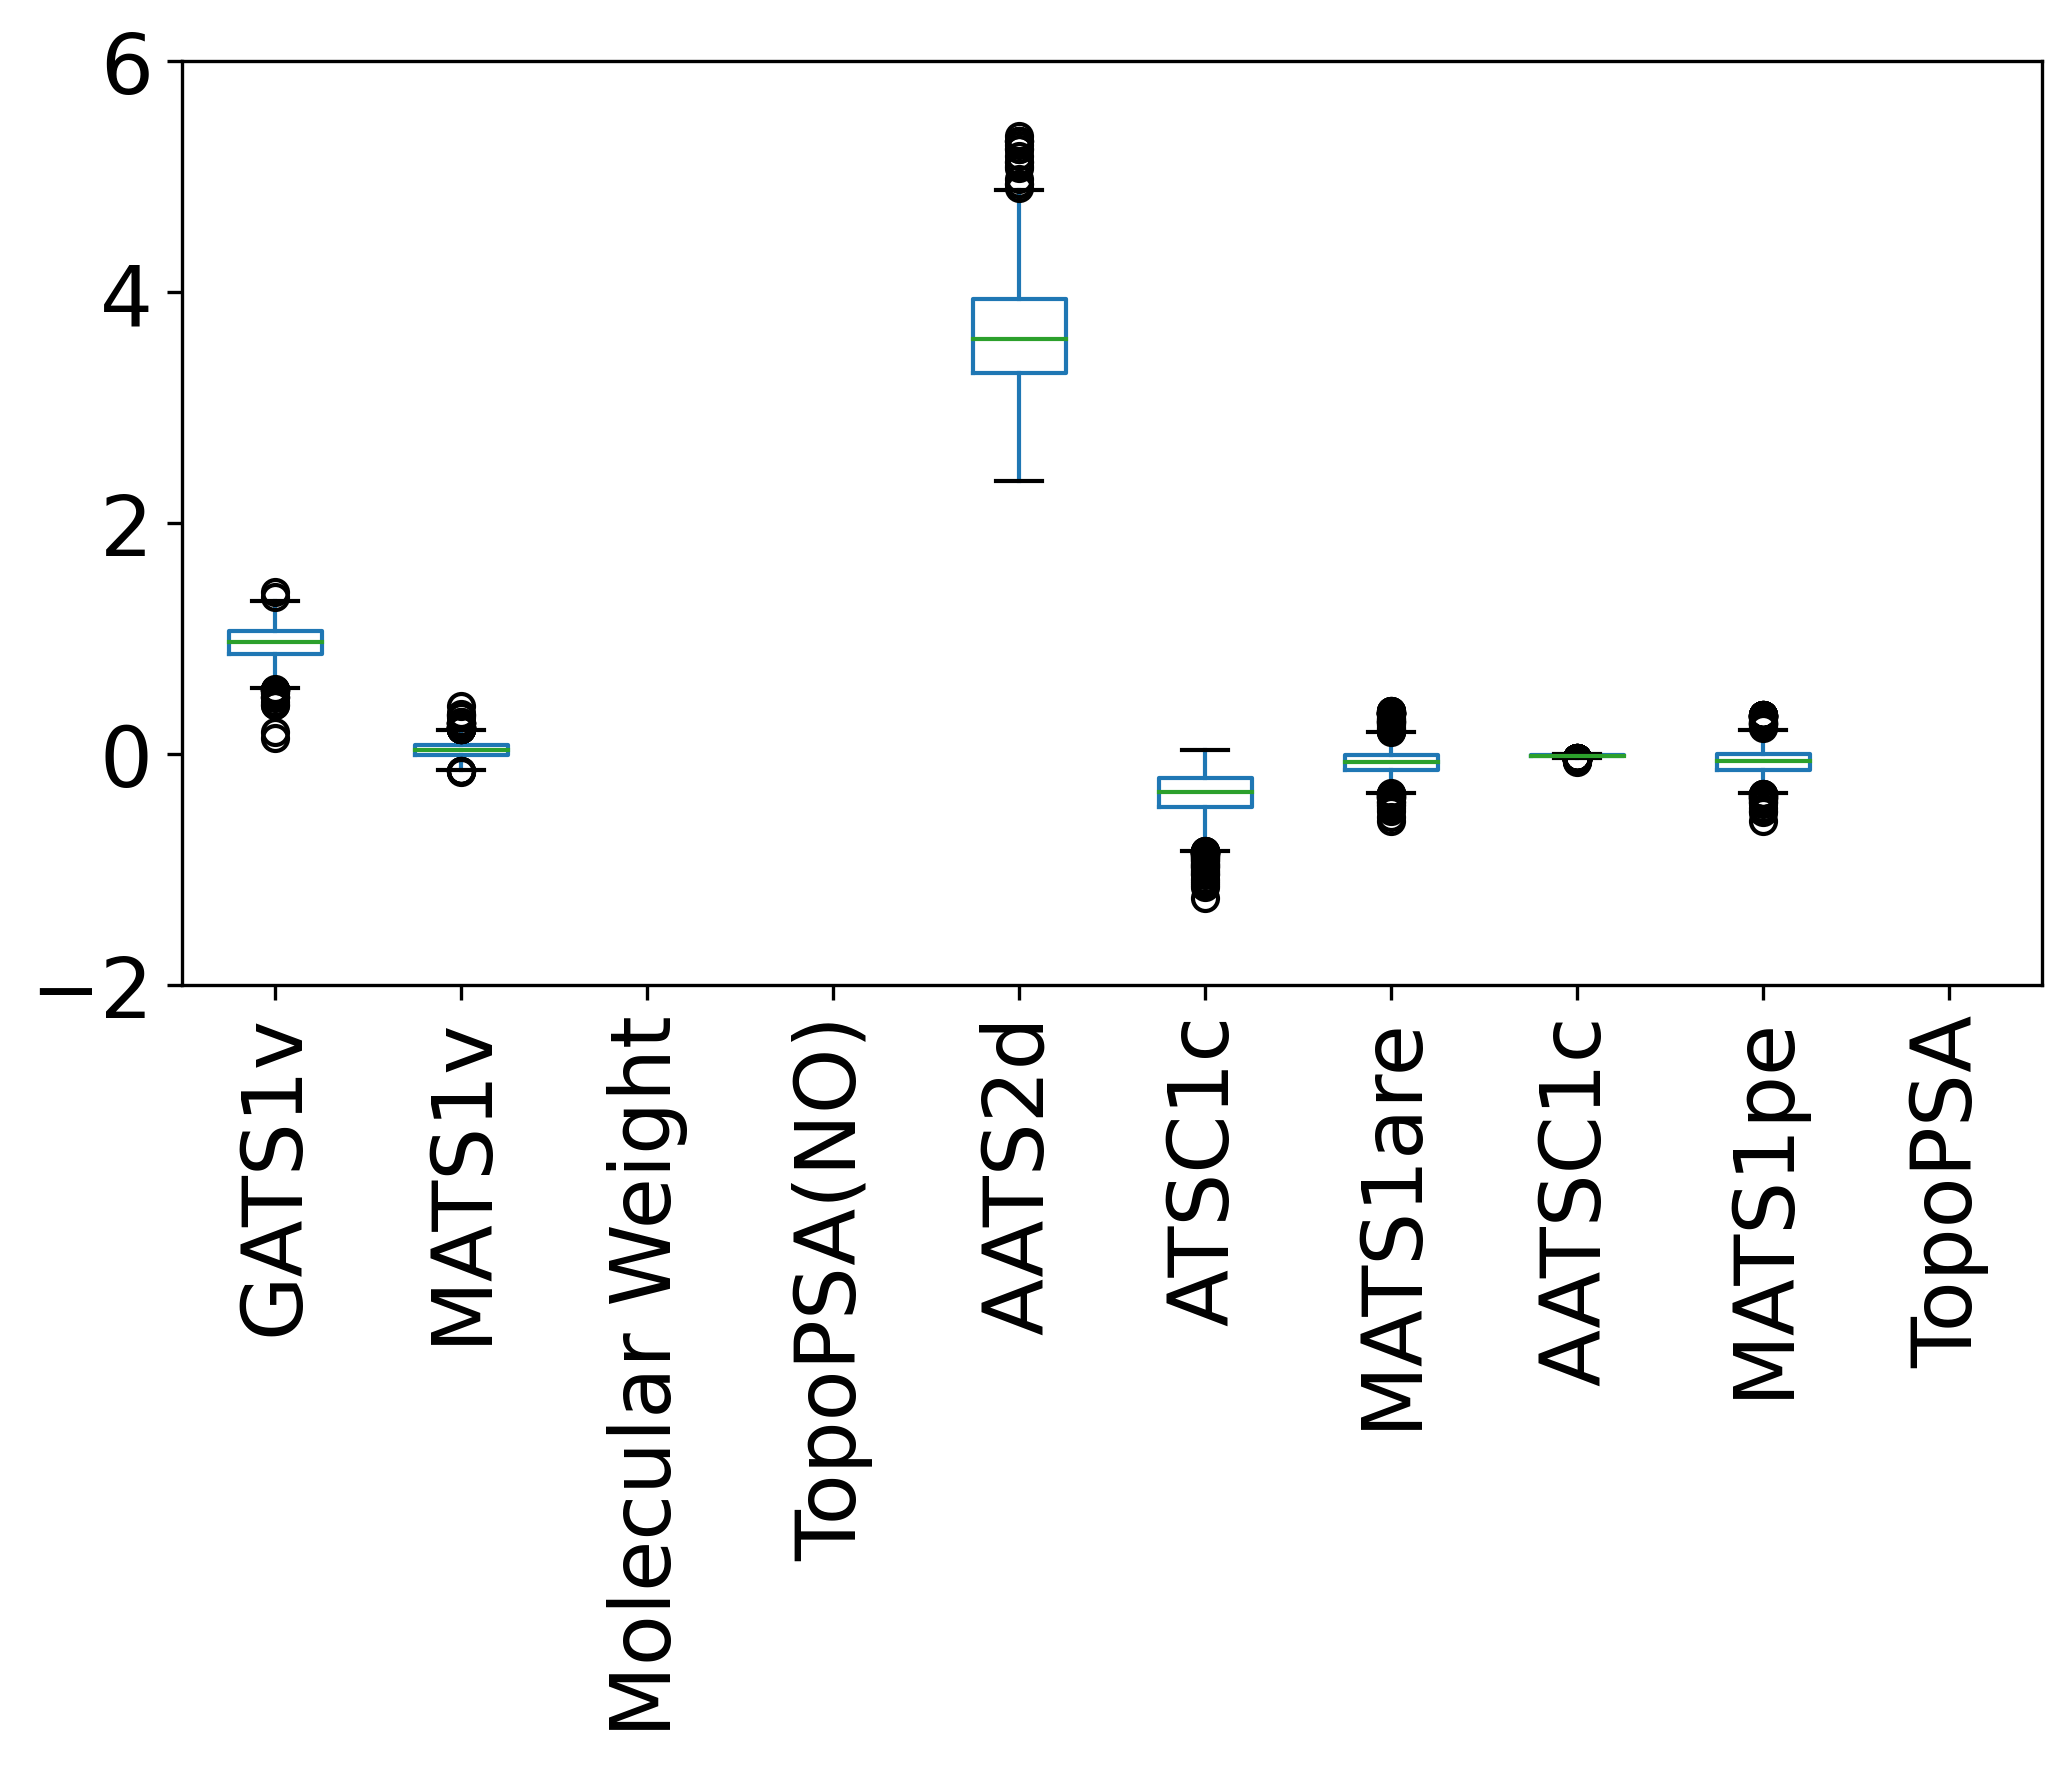

In [174]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 20

plt.figure(figsize=(8,4))
quinone_mordred = pd.read_csv('Data Files/featurized_bq.csv',low_memory=False)
hydroquinone_mordred = pd.read_csv('Data Files/featurized_hq.csv',low_memory=False)
# quinone_mordred[["PEOE_VSA8","NsssCH","SlogP_VSA4","nAcid","PEOE_VSA7","JGI2","SMR_VSA3","SaaNH","nHBDon","ZMIC0"]].boxplot(grid=False,rot=90) # top ten from ridge
# hydroquinone_mordred[["Xc-6dv","Molecular Weight","SaasN","JGI3","MATS5c","RotRatio","SaasC","ATSC4i","nRot","Xch-4dv"]].boxplot(grid=False,rot=90) # top ten from ridge
# quinone_mordred[["AATS2d","AATS2dv","AXp-6dv","MATS1se","TopoPSA(NO)","AATS3dv","AATSC0i","MATS1are","PEOE_VSA11","PEOE_VSA1"]].boxplot(grid=False,rot=90) # top ten from rf
hydroquinone_mordred[["GATS1v","MATS1v","Molecular Weight","TopoPSA(NO)","AATS2d","ATSC1c","MATS1are","AATSC1c","MATS1pe","TopoPSA"]].boxplot(grid=False,rot=90) # top ten from rf

# plt.ylim([-2,6])

# plt.savefig("Plots/HQ_Mordred_rf_ParamRanges_zoom.png",dpi=200,bbox_inches="tight")

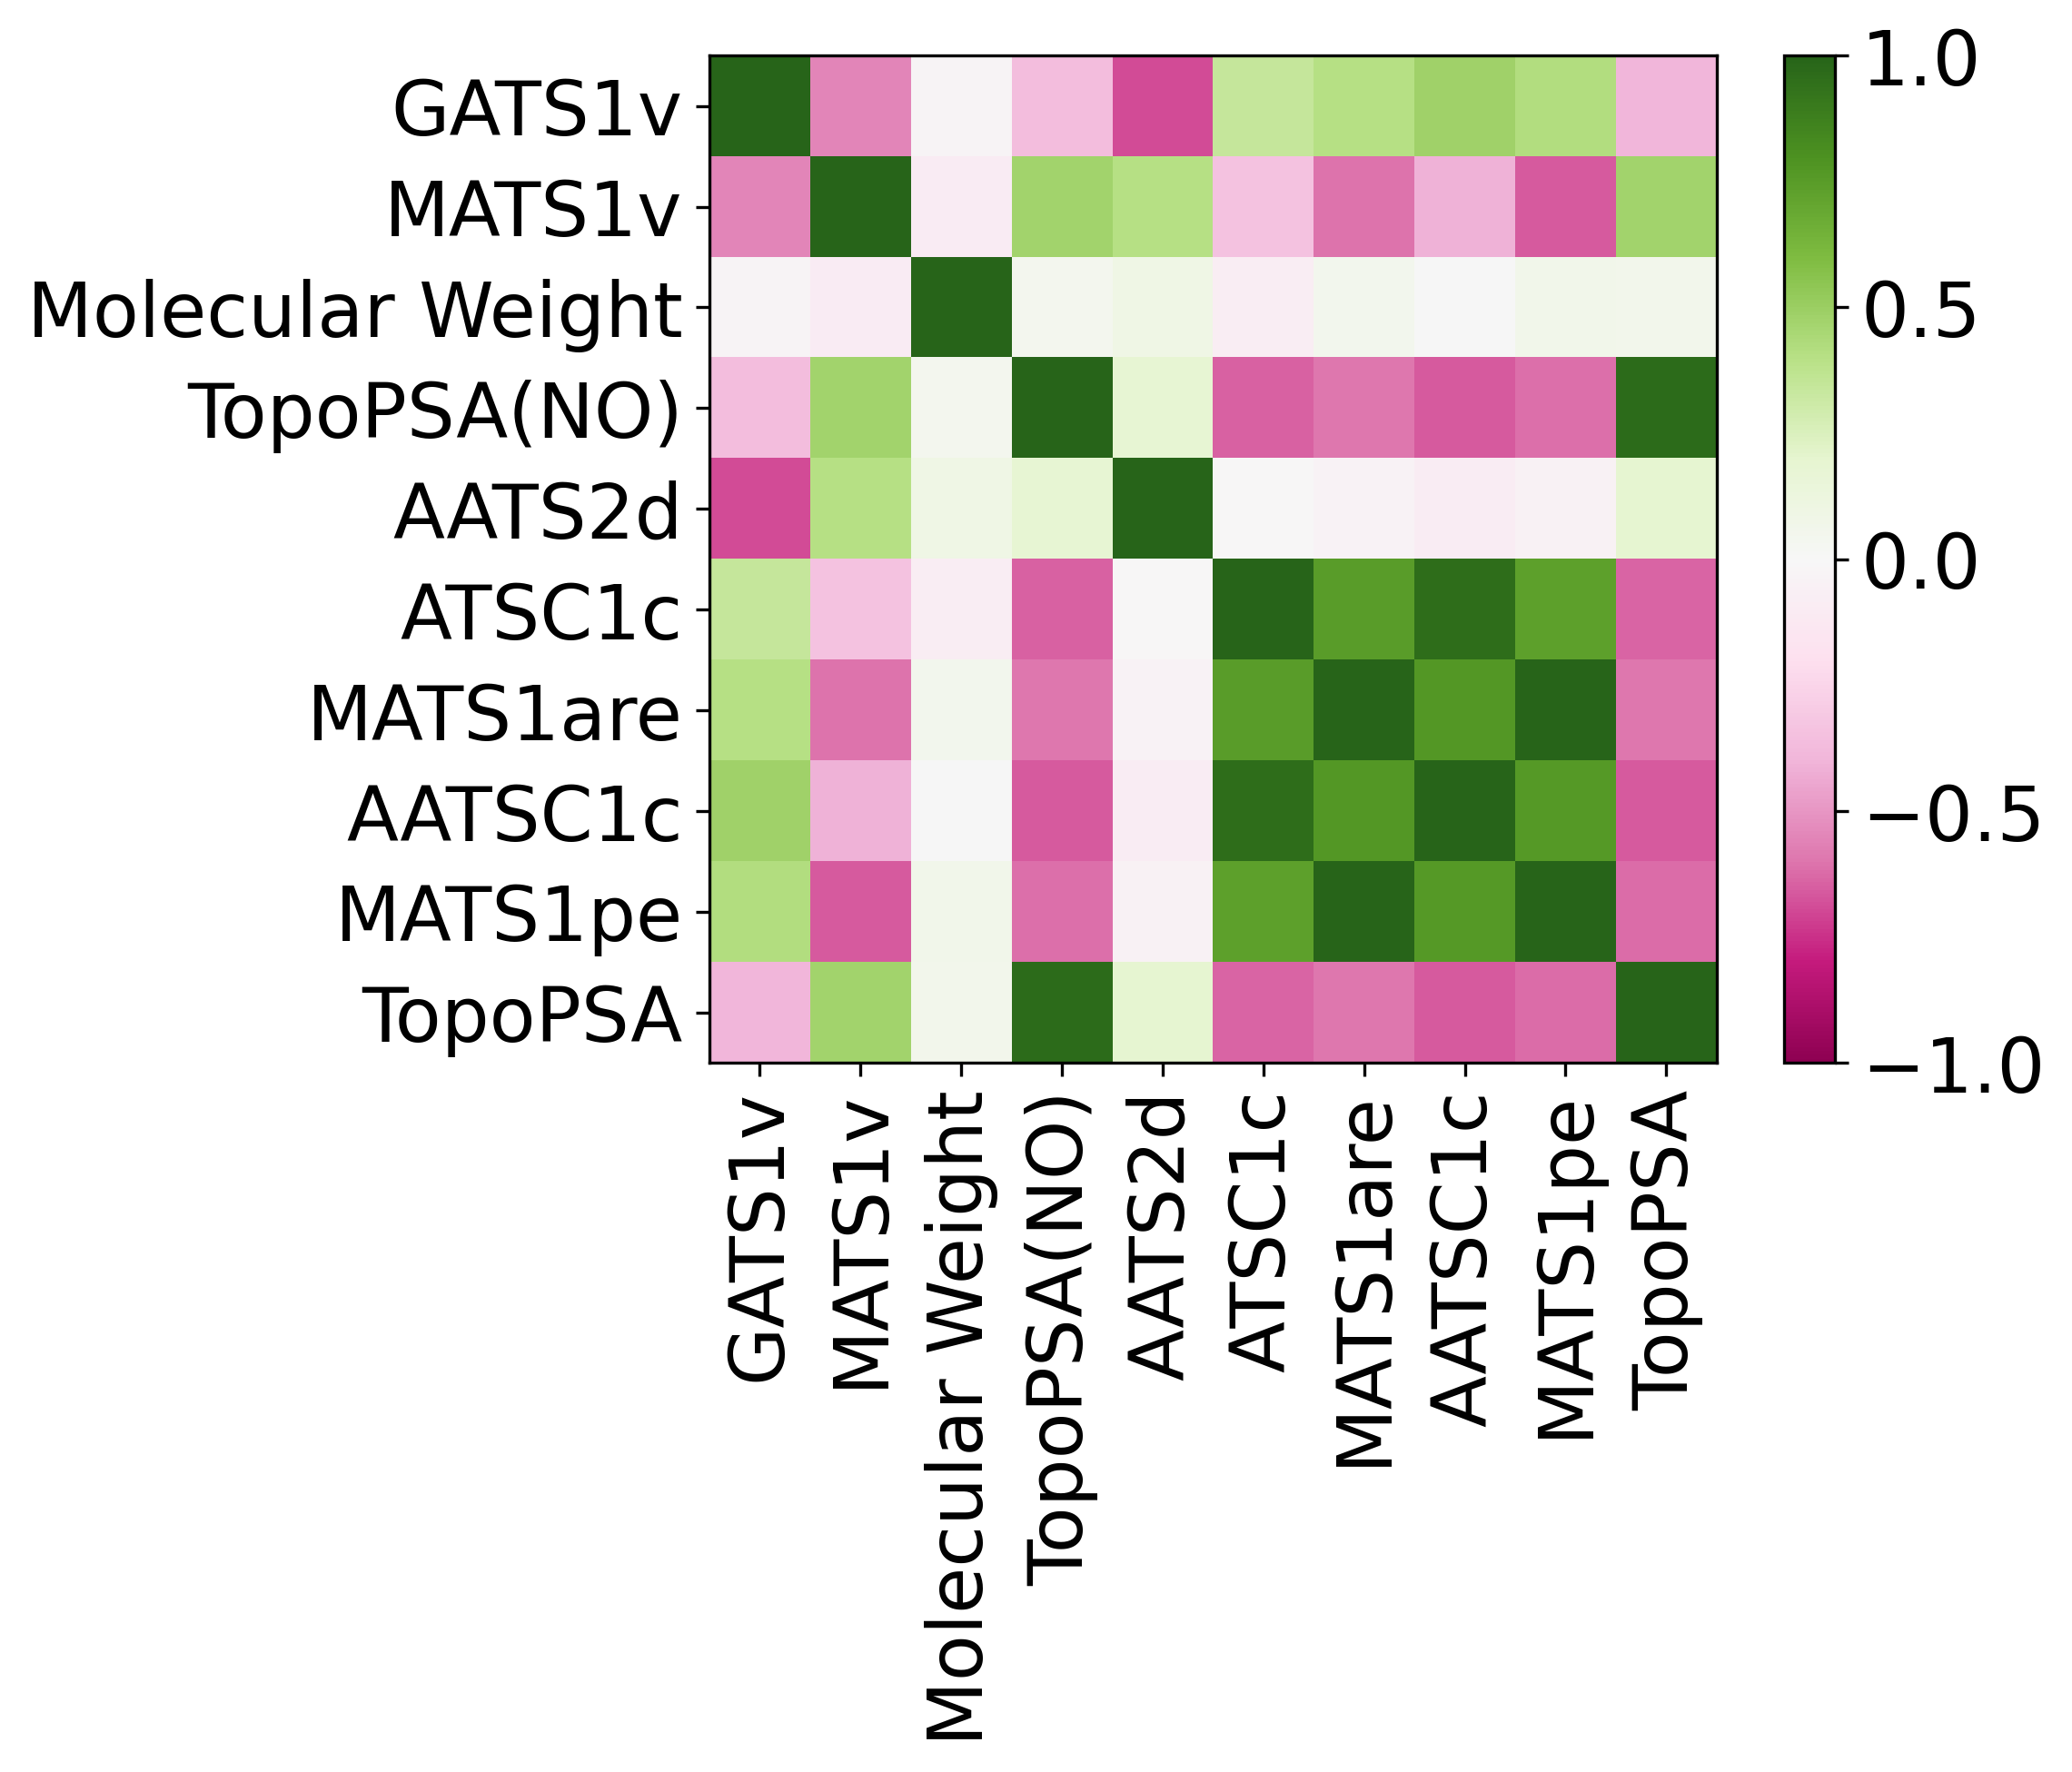

In [183]:
# corr_df = dataset_dict["Hydroquinones"][["sigma","tau","1/V_m","Eccentricity(Ear)","Eccentricity(Eal)"]].corr()
# corr_df = hydroquinone_mordred[["Molecular Weight","AATS2d","GATS4c","GATS3c","GATS1v","MATS1are","TopoPSA(NO)","MATS1v","ATSC1v","AATSC1v"]].corr() # single run feature downselected
# corr_df = quinone_mordred[["AATS2d","MATS1se","AATSC0i","AATS2dv","AXp-6dv","MATS1pe","AATS1dv","AXp-4dv","TopoPSA(NO)","TopoPSA"]].corr() # single run features downselected
# corr_df = quinone_mordred[["AATS2d","AATS2dv","AXp-6dv","MATS1se","TopoPSA(NO)","AATS3dv","AATSC0i","MATS1are","PEOE_VSA11","PEOE_VSA1"]].corr() # main text top 10 for random forest
corr_df = hydroquinone_mordred[["GATS1v","MATS1v","Molecular Weight","TopoPSA(NO)","AATS2d","ATSC1c","MATS1are","AATSC1c","MATS1pe","TopoPSA"]].corr() # main text top 10 for random forest
# corr_df = quinone_mordred[["PEOE_VSA8","NsssCH","SlogP_VSA4","nAcid","PEOE_VSA7","JGI2","SMR_VSA3","SaaNH","nHBDon","ZMIC0"]].corr() # main text top 10 ridge regression
# corr_df = hydroquinone_mordred[["Xc-6dv","Molecular Weight","SaasN","JGI3","MATS5c","RotRatio","SaasC","ATSC4i","nRot","Xch-4dv"]].corr() # main text top 10 ridge regression

fig = plt.imshow(corr_df,cmap="PiYG",vmin=-1,vmax=1)
# plt.colorbar(fig,cmap="PiYG",norm=mpl.colors.Normalize(vmin=-1, vmax=1))
plt.colorbar()
plt.xticks(range(len(corr_df)),corr_df.columns,rotation=90)
plt.yticks(range(len(corr_df.index)),corr_df.index)

# plt.savefig("Plots/HQ_Mordred_rf_correlation.png",dpi=200,bbox_inches='tight')

In [89]:
dataset_dict["Hydroquinones"][["sigma","tau","1/V_m","Eccentricity(Ear)","Eccentricity(Eal)"]].corr()

,sigma,tau,1/V_m,Eccentricity(Ear),Eccentricity(Eal)
sigma,1.000000,-0.214357,0.378293,-0.083489,-0.263878
tau,-0.214357,1.000000,-0.450278,0.180878,-0.043968
1/V_m,0.378293,-0.450278,1.000000,-0.228748,-0.541801
Eccentricity(Ear),-0.083489,0.180878,-0.228748,1.000000,-0.422589
Eccentricity(Eal),-0.263878,-0.043968,-0.541801,-0.422589,1.000000


In [24]:
ml_dataset_dict["Hydroquinones"].iloc[-1]

InChI Key            ZZPSBSRCCYSZFI-UHFFFAOYSA-N
SMILES                OC1=C2CC=C(Cl)CC2=C(O)C=C1
Molecular Weight                         196.633
H Bond Donors                                2.0
H Bond Acceptors                             0.0
Rotatable Bonds                              0.0
TPSA                                       40.46
Lipinski Number                              4.0
Veber Number                                 2.0
LogP                                       1.937
Type of Substance                      isocyclic
mp_mean                               195.666667
mp_std                                  2.953341
Name: 3214, dtype: object